In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

## Fjern data i housing data  

In [122]:
# Indlæs datasæt
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [123]:
def remove_random_values(df, column, fraction, seed=42):
    df = df.copy()
    np.random.seed(seed)
    n = int(len(df) * fraction)
    missing_idx = np.random.choice(df.index, size=n, replace=False)
    df.loc[missing_idx, column] = np.nan
    return df

# fjern 5%, 10%, 40% og 80% af værdierne i forskellige kolonner
housing = remove_random_values(housing, "total_rooms", 0.05)
housing = remove_random_values(housing, "housing_median_age", 0.10)
housing = remove_random_values(housing, "population", 0.40)
housing = remove_random_values(housing, "households", 0.80)

print("Manglende værdier (5%):", housing["total_rooms"].isnull().sum())
print("Manglende værdier (10%):", housing["housing_median_age"].isnull().sum())
print("Manglende værdier (40%):", housing["population"].isnull().sum())
print("Manglende værdier (80%):", housing["households"].isnull().sum())

# Fjern værdier i kategorisk kolonne ("Fake NaN")
replace_idx = np.random.choice(housing.index, size=20, replace=False)
housing.loc[replace_idx, "ocean_proximity"] = "Na"

print(housing["ocean_proximity"].value_counts())

# save csv
housing.to_csv("housing_missing.csv", index=False)


Manglende værdier (5%): 1032
Manglende værdier (10%): 2064
Manglende værdier (40%): 8256
Manglende værdier (80%): 16512
ocean_proximity
<1H OCEAN     9124
INLAND        6548
NEAR OCEAN    2655
NEAR BAY      2288
Na              20
ISLAND           5
Name: count, dtype: int64


## Opgave 1

In [124]:
housing = pd.read_csv("housing_missing.csv")

housing.head()

housing.isna().sum()

len(housing)

20640

Dataset shape: (20640, 10)
Missing values:
longitude                 0
latitude                  0
housing_median_age     2064
total_rooms            1032
total_bedrooms          207
population             8256
households            16512
median_income             0
median_house_value        0
ocean_proximity           0
dtype: int64


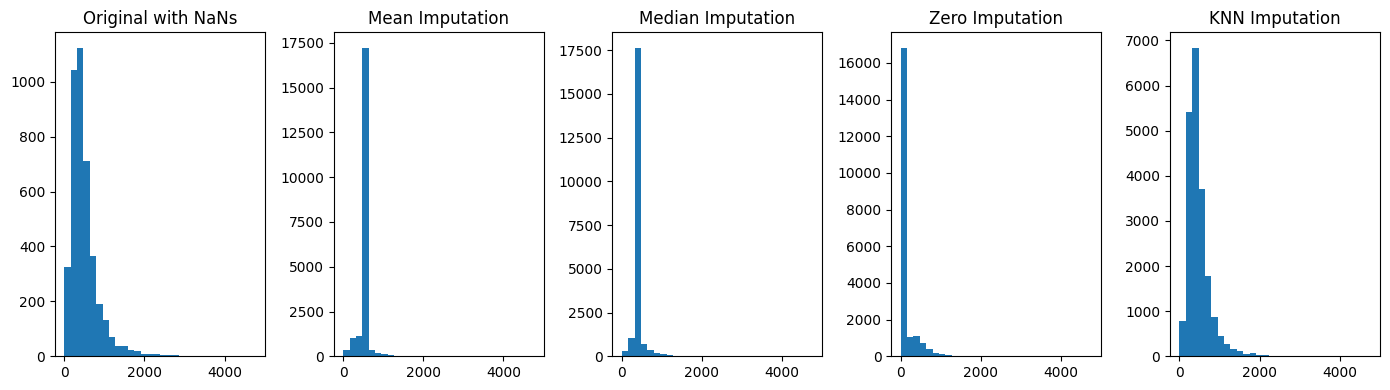

In [125]:
# Tjek missing values
print("Dataset shape:", housing.shape)

print("Missing values:")
print(housing.isnull().sum())

# Vælg kun numeriske kolonner
num_features = housing.select_dtypes(include=[np.number]).columns

# Simple imputers på alle numeriske features
imputer_mean = SimpleImputer(strategy="mean")
imputer_median = SimpleImputer(strategy="median")
imputer_zero = SimpleImputer(strategy="constant", fill_value=0)

housing_mean = pd.DataFrame(imputer_mean.fit_transform(housing[num_features]),
                            columns=num_features)
housing_median = pd.DataFrame(imputer_median.fit_transform(housing[num_features]),
                              columns=num_features)
housing_zero = pd.DataFrame(imputer_zero.fit_transform(housing[num_features]),
                            columns=num_features)

# Avanceret: KNN-imputer
knn_imputer = KNNImputer(n_neighbors=5)
housing_knn = pd.DataFrame(knn_imputer.fit_transform(housing[num_features]),
                           columns=num_features)

# Visualiser ét eksempel-feature for at sammenligne (fx households)
column_to_plot = "households"
fig, axs = plt.subplots(1, 5, figsize=(14, 4))
axs[0].hist(housing[column_to_plot].dropna(), bins=30)
axs[0].set_title("Original with NaNs")
axs[1].hist(housing_mean[column_to_plot], bins=30)
axs[1].set_title("Mean Imputation")
axs[2].hist(housing_median[column_to_plot], bins=30)
axs[2].set_title("Median Imputation")
axs[3].hist(housing_zero[column_to_plot], bins=30)
axs[3].set_title("Zero Imputation")
axs[4].hist(housing_knn[column_to_plot], bins=30)
axs[4].set_title("KNN Imputation")
plt.tight_layout()
plt.show()

## Opgave 2

In [126]:
print("Value counts - ocean_proximity:")
print(housing["ocean_proximity"].value_counts())

Value counts - ocean_proximity:
ocean_proximity
<1H OCEAN     9124
INLAND        6548
NEAR OCEAN    2655
NEAR BAY      2288
Na              20
ISLAND           5
Name: count, dtype: int64


In [127]:
housing["ocean_proximity"] = housing["ocean_proximity"].replace("Na", np.nan)

cat_imputer = SimpleImputer(strategy="most_frequent")  # eller "constant", fill_value="missing"
housing["ocean_proximity"] = pd.DataFrame(cat_imputer.fit_transform(housing[["ocean_proximity"]]),
                            columns=["ocean_proximity"])

In [128]:

# Label Encoding
ordinal_encoder = OrdinalEncoder()
housing_ordinal = housing.copy()
housing_ordinal["ocean_encoded"] = ordinal_encoder.fit_transform(housing[["ocean_proximity"]])

print("Label encoded:")
print(housing_ordinal[["ocean_proximity", "ocean_encoded"]].head())

# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
ocean_1hot = onehot_encoder.fit_transform(housing[["ocean_proximity"]])
ocean_1hot_df = pd.DataFrame(ocean_1hot, columns=onehot_encoder.get_feature_names_out(["ocean_proximity"]))

print("One-hot encoded:")
print(ocean_1hot_df.head())

Label encoded:
  ocean_proximity  ocean_encoded
0        NEAR BAY            3.0
1        NEAR BAY            3.0
2        NEAR BAY            3.0
3        NEAR BAY            3.0
4        NEAR BAY            3.0
One-hot encoded:
   ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        0.0                     0.0                     0.0   
2                        0.0                     0.0                     0.0   
3                        0.0                     0.0                     0.0   
4                        0.0                     0.0                     0.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       1.0                         0.0  
1                       1.0                         0.0  
2                       1.0                         0.0  
3                       1.0                         0.0  

## Opgave 3

StandardScaler (z-score) sample:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0  -1.327835  1.052548            0.983513    -0.803407       -0.970325   
1  -1.322844  1.043185           -0.604269     2.040954        1.348276   
2  -1.332827  1.038503            1.856793    -0.534933       -0.825561   
3  -1.337818  1.038503                 NaN    -0.623205       -0.718768   
4  -1.337818  1.038503            1.856793    -0.461755       -0.611974   

   population  households  median_income  median_house_value  
0         NaN         NaN       2.344766            2.129631  
1    0.864248         NaN       2.332238            1.314156  
2   -0.829946         NaN       1.782699            1.258693  
3         NaN         NaN       0.932968            1.165100  
4   -0.768582         NaN      -0.012881            1.172900  
MinMaxScaler sample:
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.211155  0.567481            0.784314

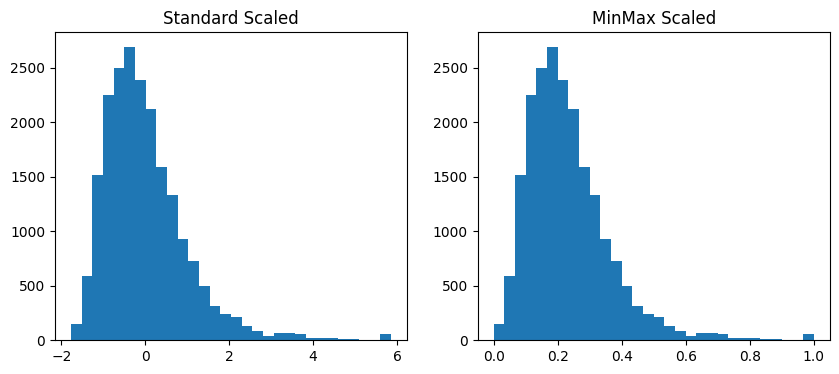

In [129]:
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

print("StandardScaler (z-score) sample:")
housing_standard = pd.DataFrame(scaler_standard.fit_transform(housing[num_features]),
                            columns=num_features)
print(housing_standard.head())

print("MinMaxScaler sample:")
housing_minmax = pd.DataFrame(scaler_minmax.fit_transform(housing[num_features]),
                            columns=num_features)
print(housing_minmax.head())

# Plot distribution of one feature
column_to_plot = "median_income"
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(housing_standard[column_to_plot], bins=30)
plt.title("Standard Scaled")
plt.subplot(1,2,2)
plt.hist(housing_minmax[column_to_plot], bins=30)
plt.title("MinMax Scaled")
plt.show()

## Opgave 4

In [130]:
# Opdel i træning og test
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train.select_dtypes(include=["float64", "int64"]))
# X_test_imputed = imputer.transform(X_test)

model = LinearRegression()
scores = cross_val_score(model, X_train_imputed, y_train, cv=10, scoring="r2")

print("Cross-validation results (Linear Regression):")
print("Scores:", scores)
print("Mean R^2:", scores.mean())
print("Std:", scores.std())

Cross-validation results (Linear Regression):
Scores: [0.61992846 0.56692874 0.62463808 0.6280262  0.61151045 0.65418549
 0.65130469 0.60149863 0.61878583 0.62985259]
Mean R^2: 0.6206659155034924
Std: 0.023578831374588407


## Ekstra opgave - Fine-tuning

In [ ]:
iris = pd.read_csv("iris.csv")

X = iris.iloc[:, 0:2].values 
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
# X_test_imputed = imputer.transform(X_test)

param_grid = {"n_neighbors": [3, 5, 7, 9, 11]}
knn = KNeighborsClassifier(n_neighbors=5)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_imputed, y_train)

print("Best parameters (KNN):", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters (KNN): {'n_neighbors': 9}
Best score: 0.780952380952381
